## Jump Ambiguity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
# Enable LaTeX fonts in plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [ ]:
# Parameters (Branger and Larsen 2013)
r = 0.02
sigma = 0.2
mu = 0.06
jS = -0.15
lambdaP = 0.1
muN = 0.03
T = 10

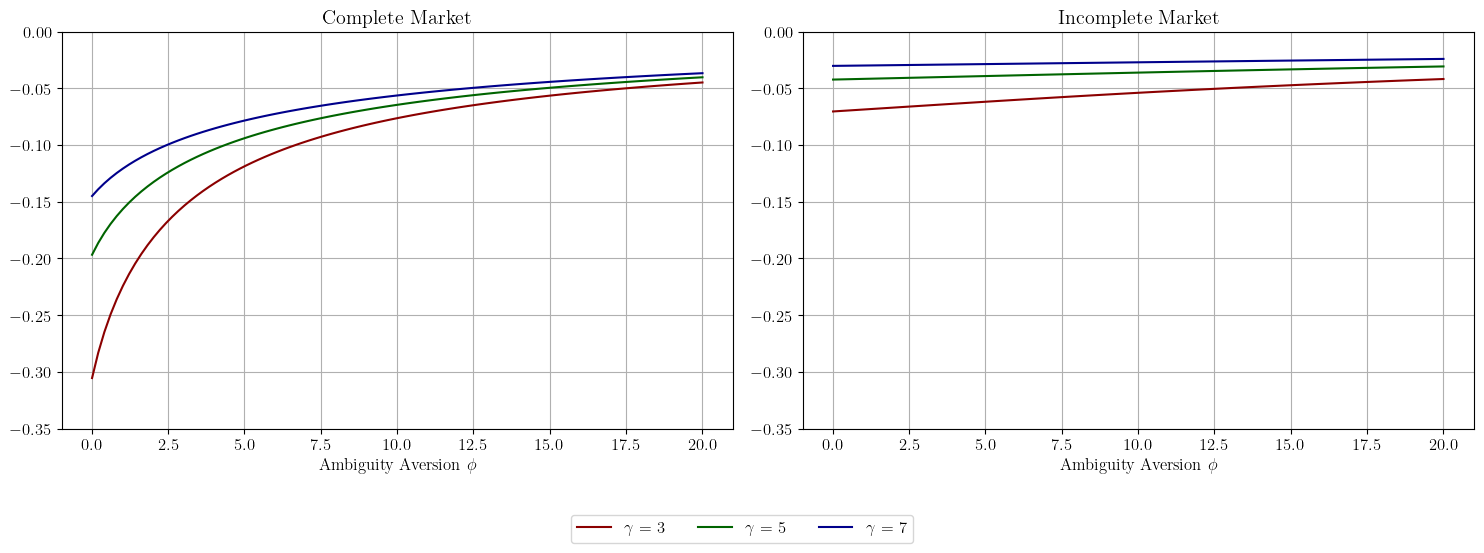

In [ ]:
theta_vals = np.linspace(0.01, 20, 100)
gamma_list = [3, 5, 7]
colors = ['darkred', 'darkgreen', 'darkblue']

alphaN_complete = []
alphaN_incomplete = []

def optimal_alphaN_c(theta_N, gamma):
    def eq(alpha_N):
        exp_term = np.exp(-(theta_N / (1 - gamma)) * ((1 + alpha_N) ** (1 - gamma) - 1))
        return exp_term * (1 + alpha_N) ** (-gamma) * lambdaP - lambdaP + muN / jS
    return fsolve(eq, x0=-0.3)[0]

def optimal_alpha_ic(theta_N, gamma):
    def eq(alpha):
        term1 = (mu - jS * lambdaP) / sigma ** 2
        exp_term = np.exp(-(theta_N / (1 - gamma)) * ((1 + alpha * jS) ** (1 - gamma) - 1))
        term2 = (1 + alpha * jS) ** (-gamma) * jS * lambdaP * exp_term / sigma ** 2
        return alpha - (1 / gamma) * (term1 + term2)
    return fsolve(eq, x0=0.2)[0]

for gamma in gamma_list:
    complete_path = []
    incomplete_path = []
    for theta in theta_vals:
        alpha_N = optimal_alphaN_c(theta, gamma)
        alpha_ic = optimal_alpha_ic(theta, gamma)
        complete_path.append(alpha_N)
        incomplete_path.append(alpha_ic * jS)  # effective jump exposure
    alphaN_complete.append(complete_path)
    alphaN_incomplete.append(incomplete_path)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for path, gamma, color in zip(alphaN_complete, gamma_list, colors):
    axs[0].plot(theta_vals, path, label=f'$\\gamma$ = {gamma}', color=color)
axs[0].set_title('Complete Market')
axs[0].set_xlabel(r'Ambiguity Aversion $\phi$')
axs[0].grid(True)
axs[0].set_ylim(-0.35, 0)
#axs[0].set_xlim(0, 20)

for path, gamma, color in zip(alphaN_incomplete, gamma_list, colors):
    axs[1].plot(theta_vals, path, label=f'$\\gamma$ = {gamma}', color=color)
axs[1].set_title('Incomplete Market')
axs[1].set_xlabel(r'Ambiguity Aversion $\phi$')
axs[1].grid(True)
axs[1].set_ylim(-0.35, 0)
#axs[1].set_xlim(0, 20)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=5)

plt.tight_layout()
plt.savefig("Jump_ambiguity_exposure.png", dpi=600, bbox_inches='tight')
plt.show()


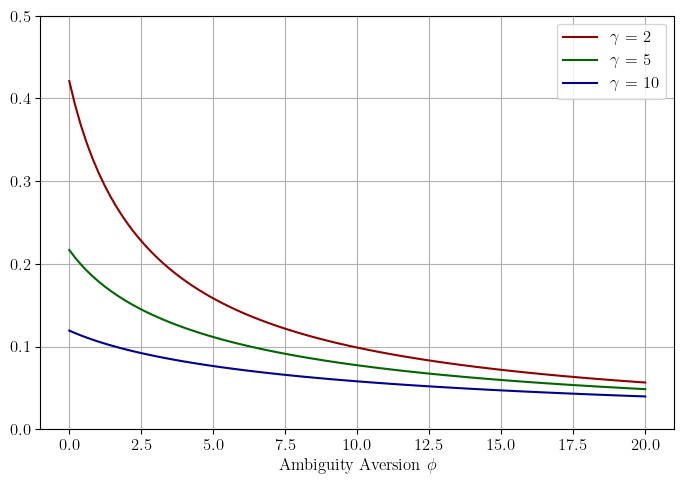

In [ ]:
theta_vals = np.linspace(0.01, 20, 100)
gamma_list = [2, 5, 10]
colors = ['darkred', 'darkgreen', 'darkblue']

def A_c(theta, alpha_z, alpha_N, gamma):
    base = ((1 - gamma) * (r + alpha_z * (mu / sigma) + alpha_N * (-lambdaP + muN / jS))
            - 0.5 * (1 - gamma) * (gamma + theta) * alpha_z ** 2)
    if theta == 0:
        return base * T
    else:
        jump_term = (1 - np.exp(-(theta / (1 - gamma)) * ((1 + alpha_N) ** (1 - gamma) - 1)))
        return (base + (1 - gamma) / theta * jump_term * lambdaP) * T

def A_ic(theta, alpha, gamma):
    base = ((1 - gamma) * (r + alpha * (mu - jS * lambdaP))
            - 0.5 * (1 - gamma) * (gamma + theta) * alpha ** 2 * sigma ** 2)
    if theta == 0:
        return base * T
    else:
        jump_term = (1 - np.exp(-(theta / (1 - gamma)) * ((1 + alpha * jS) ** (1 - gamma) - 1)))
        return (base + (1 - gamma) / theta * jump_term * lambdaP) * T

def optimal_alphaN_c(theta, gamma):
    def eq(alpha_N):
        exp_term = np.exp(-(theta / (1 - gamma)) * ((1 + alpha_N) ** (1 - gamma) - 1))
        return exp_term * (1 + alpha_N) ** (-gamma) * lambdaP - lambdaP + muN / jS
    return fsolve(eq, x0=-0.3)[0]

def optimal_alpha_ic(theta, gamma):
    def eq(alpha):
        term1 = (mu - jS * lambdaP) / sigma ** 2
        exp_term = np.exp(-(theta / (1 - gamma)) * ((1 + alpha * jS) ** (1 - gamma) - 1))
        term2 = (1 + alpha * jS) ** (-gamma) * jS * lambdaP * exp_term / sigma ** 2
        return alpha - (1 / (gamma + theta)) * (term1 + term2)
    return fsolve(eq, x0=0.2)[0]

loss_all = []

for gamma in gamma_list:
    L = []
    for theta in theta_vals:
        # Complete market strategy
        alpha_z = mu / sigma / (gamma + theta)
        alpha_N = optimal_alphaN_c(theta, gamma)
        A_comp = A_c(theta, alpha_z, alpha_N, gamma)

        # Incomplete market strategy
        alpha_ic = optimal_alpha_ic(theta, gamma)
        A_incomp = A_ic(theta, alpha_ic, gamma)

        # Loss from incompleteness
        loss = 1 - np.exp((A_incomp - A_comp) / (1 - gamma))
        L.append(loss)
    loss_all.append(L)

# Plot
plt.figure(figsize=(7, 5))
for L, gamma, color in zip(loss_all, gamma_list, colors):
    plt.plot(theta_vals, L, label=f'$\\gamma$ = {gamma}', color=color)
#plt.title('Utility Loss from Market Incompleteness')
plt.xlabel(r'Ambiguity Aversion $\phi$')
#plt.xlim(0, 20)
plt.ylim(0, 0.5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Jump_ambiguity_utility.png", dpi=600, bbox_inches='tight')
plt.show()
